In [1]:
import os.path
import sys
import django
sys.path.append('/home/galm/software/django/tmv/BasicBrowser')
sys.path.append('/home/max/software/django-tmv/tmv_mcc-apsis/BasicBrowser')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()
import scoping
from scoping.models import *
from utils.text import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC

import pandas as pd
import numpy as np

import pickle
import scipy.sparse

import matplotlib.pyplot as plt

In [2]:
seen_df = pd.read_csv('../data/0_labelled_documents.csv')

df = (seen_df
      .sort_values('id')
      .sample(frac=1, random_state=1)
      .reset_index(drop=True)
)

print(seen_df.shape)

seen_index = df[df['seen']==1].index
unseen_index = df[df['seen']==0].index
new_index = df[(df['seen']==1) & (df['ar5']==0)].index
rel_index = df[df['relevant']==1].index
r_index = df[df["random_sample"]==1].index
physical_index = df[df['physical_tags']==1].index

(2312, 243)


In [3]:
from alterations import postfix_data
df = postfix_data(df)

In [4]:
revectorize = True

X_exists = os.path.isfile(f'../data/X_{seen_df.shape[0]}.npz')

if revectorize is True or X_exists is False:
    print("running vectorisation again")
    vec = TfidfVectorizer(
        ngram_range=(1,2),
        min_df=5, max_df=0.8, strip_accents='unicode', 
        max_features=20000,
        #tokenizer=snowball_stemmer()
    )

    X = vec.fit_transform(df['content'].astype("str"))   
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','wb') as f:
        pickle.dump(vec, f)
    import scipy.sparse
    scipy.sparse.save_npz(f'../data/X_{seen_df.shape[0]}.npz', X)
else:
    print("loading feature matrix")
    with open (f'../data/vec_{seen_df.shape[0]}.pickle','rb') as f:
        vec = pickle.load(f)
        X = scipy.sparse.load_npz(f'../data/X_{seen_df.shape[0]}.npz')
        
X.shape

running vectorisation again


(2312, 20000)

In [5]:
broad_cats = [x for x in df.columns if "12 - " in x and "Physical systems" not in x and "prediction" not in x]
broad_cats

['12 - Coastal and marine Ecosystems',
 '12 - Human and managed',
 '12 - Mountains, snow and ice',
 '12 - Rivers, lakes, and soil moisture',
 '12 - Terrestrial ES']

In [6]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[broad_cats])
print(y.shape)

multimodels = [
    {
       'title': 'One vs rest SVC balanced rbf', 
       'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced"))
    },  
    {
       'title': 'One vs rest SVC balanced rbf C10', 
       'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced", C=10))
    },
    {
        'title': 'One vs rest SVC balanced C10', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=10))
    },   
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },  
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_ar5, metrics, df = lu.cross_validate_models(X, y, multimodels, rel_index, n_splits=10, classes=broad_cats, df = df)


(2312, 5)
1
2
3
4
5
6
7
8
9
10


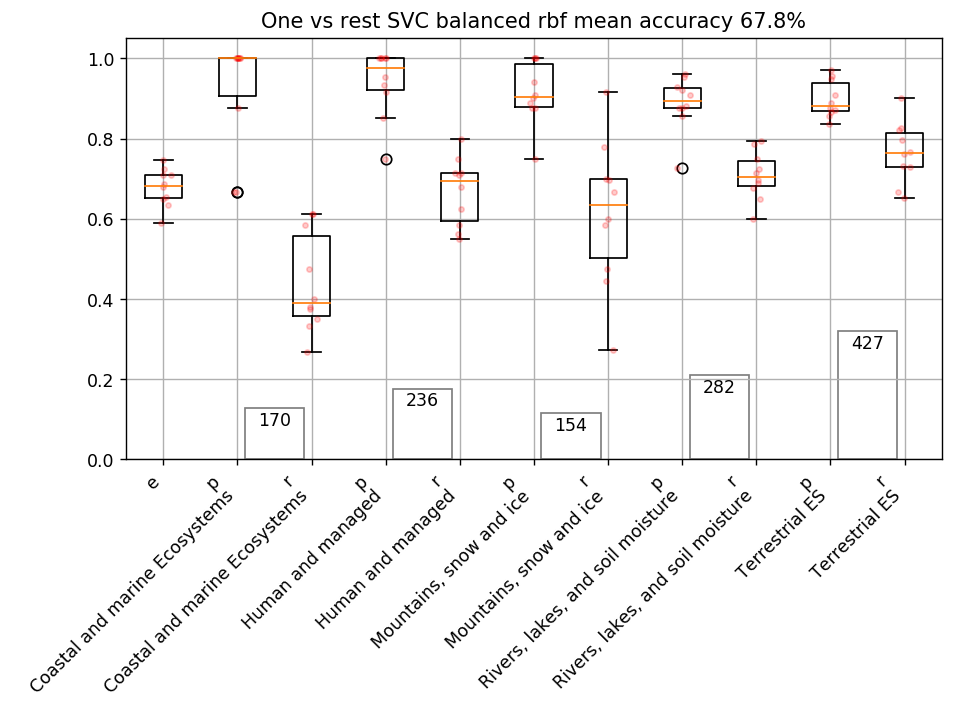

In [7]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[0]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

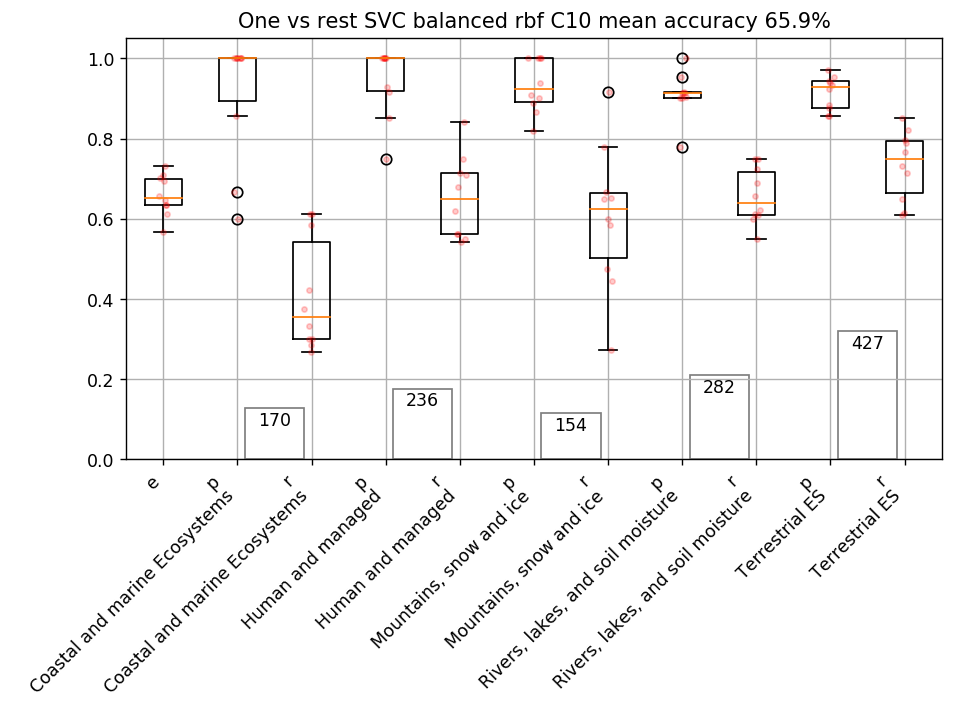

In [8]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[1]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

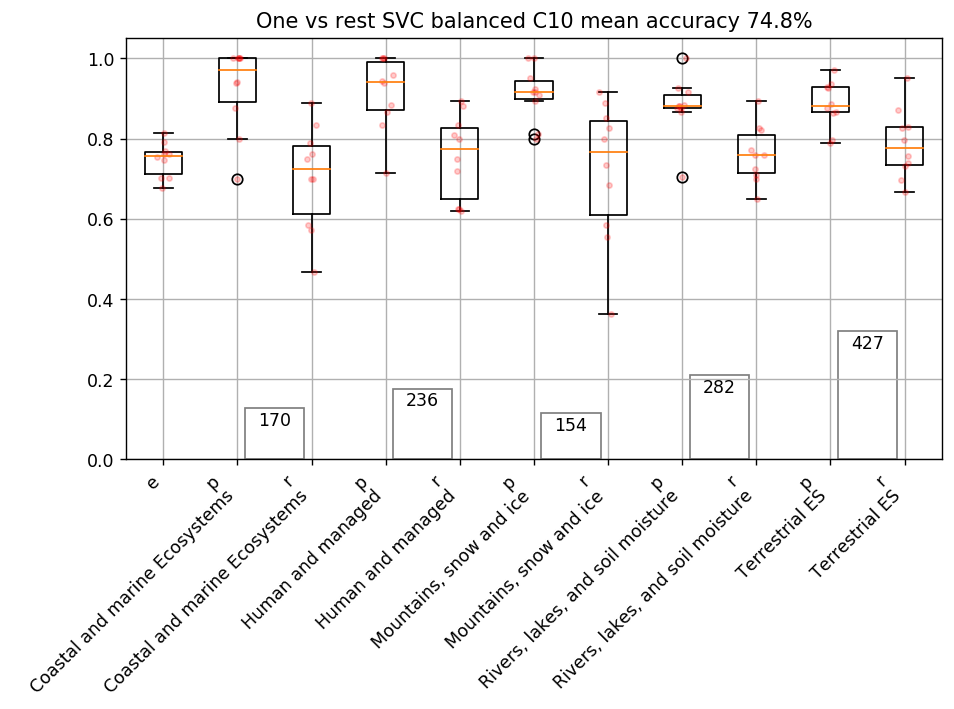

In [9]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[2]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

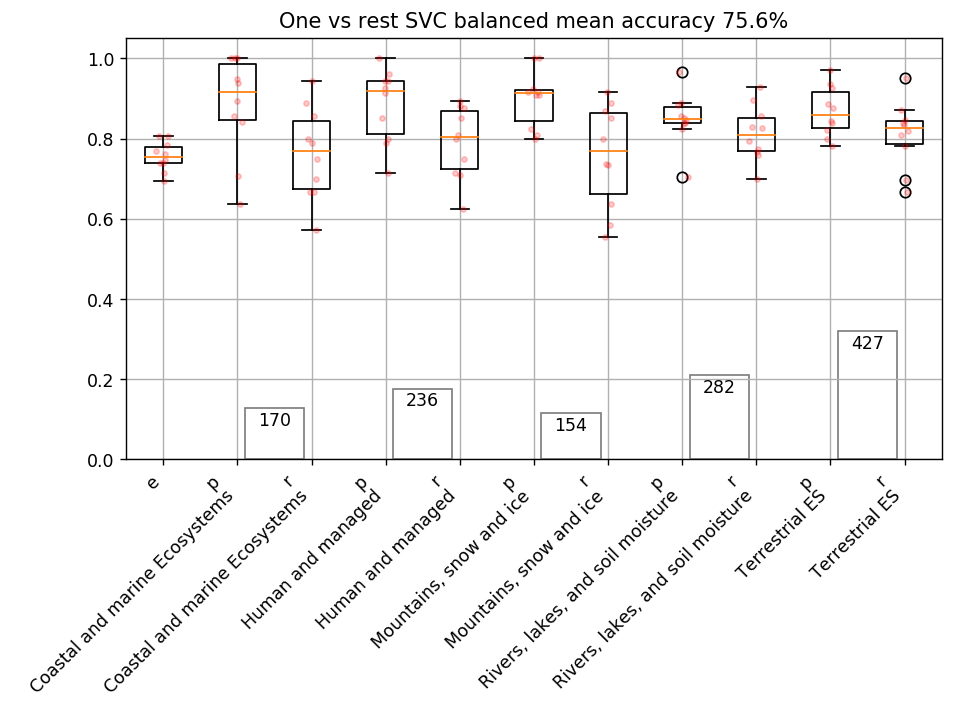

In [10]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output([multimodels_ar5[3]], metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(metrics):
    if len(m)>2:
        v,c = m.split('\n')
        s = df.loc[rel_index,c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

In [11]:
# 73.7 72.2 68.9 66.4

In [12]:
c = "12 - Coastal and marine Ecosystems"
cp = c +" - k_prediction"
fpfn = df[
    (df[cp]>0.5) & 
    (df[c]==0)
]
for i, row in fpfn.sort_values(cp,ascending=False).reset_index(drop=True).iterrows():
    print("\n####\n")
    print(row['title'])
    print(row["content"])
    print(row[cp])
    print(row[c])
    d = Doc.objects.get(pk=row['id'])
    
    dcs = Category.objects.filter(docusercat__doc=d, level__in=[4,6,12])
    if not dcs.exists():
        dcs = Category.objects.filter(docusercat__doc=d)
        print(dcs)
        print(d.docownership_set.filter(query__project=178).values('user__username','relevant','tag__title'))
        print(d.query.filter(project=178).values('id','title'))
    print(dcs.values('name','level'))
    print(d.id)


####

Recent sea level change in the Mediterranean sea revealed by Topex/Poseidon satellite altimetry
Using altimetry data of the Topex/Poseidon satellite available since early 1993, we show that the eastern Mediterranean sea level has been continuously rising during 1993-1999, at a rate up to 20 mm/yr southeast of Crete. Sea level rise is also observed in the Algerian-Provencal basin as well as in the Tyrrhenian and Adriatic seas. The north Ionian sea, on the other hand, shows an opposite trend, i.e., a sea level drop during the past seven years. Sea surface temperature trends are strongly correlated to sea level trends, indicating that at least part of the observed sea level change has a thermal origin. The recent Mediterranean sea level rise observed by Topex/Poseidon may be related to the warming trends reported from hydrographic cruises in the intermediate and deep waters of the eastern basin since the early 1990s, and of the western basin since the 1960s.
0.9931739225893128
0.0


In [13]:
#### print(c)
fpfn = df[
    (df[cp]<0.5) & 
    (df[c]==1)
]
for i, row in fpfn.sort_values(cp,ascending=True).reset_index(drop=True).iterrows():
    print("\n####\n")
    print(row['title'])
    print(row["content"])
    print(row[cp])
    print(row[c])
    d = Doc.objects.get(pk=row['id'])
    
    dcs = Category.objects.filter(docusercat__doc=d, level__in=[4,6,12])
    if not dcs.exists():
        print(d.docownership_set.filter(query__project=178).values('user__username','relevant','tag__title'))
        print(d.query.filter(project=178).values('id','title'))
    print(dcs.values('name','level'))
    print(d.id)


####

Genetic change for earlier migration timing in a pink salmon population
To predict how climate change will influence populations, it is necessary to understand the mechanisms, particularly microevolution and phenotypic plasticity, that allow populations to persist in novel environmental conditions. Although evidence for climate-induced phenotypic change in populations is widespread, evidence documenting that these phenotypic changes are due to microevolution is exceedingly rare. In this study, we use 32 years of genetic data (17 complete generations) to determine whether there has been a genetic change towards earlier migration timing in a population of pink salmon that shows phenotypic change; average migration time occurs nearly two weeks earlier than it did 40 years ago. Experimental genetic data support the hypothesis that there has been directional selection for earlier migration timing, resulting in a substantial decrease in the late-migrating phenotype (from more than 30%

<QuerySet []>
115394

####

Physiological response of the coralline alga Corallina officinalis L. to both predicted long-term increases in temperature and short-term heatwave events
Climate change is leading to an increase of mean sea surface temperatures and extreme heat events. There is an urgent need to better understand the capabilities of marine macroalgae to adapt to these rapid changes. In this study, the responses of photosynthesis, respiration, and calcification to elevated temperature in a global warming scenario were investigated in the coralline alga Corallina officinalis. Algae were cultured for 7 weeks under 4 temperature treatments: (1) control under ambient-summer conditions (C, similar to 20 degrees C), (2) simulating a one-week heatwave of 1 degrees C (HW, T-control+1 degrees C), (3) elevated temperature (+3, T-control +3 degrees C), (4) combination of the two previous treatments (HW+3, T+3+1 degrees C). After exposure at T+ 3 (up to a T-max of similar to 23 degrees C

['12 - Coastal and marine Ecosystems', '12 - Human and managed', '12 - Mountains, snow and ice', '12 - Rivers, lakes, and soil moisture', '12 - Terrestrial ES']


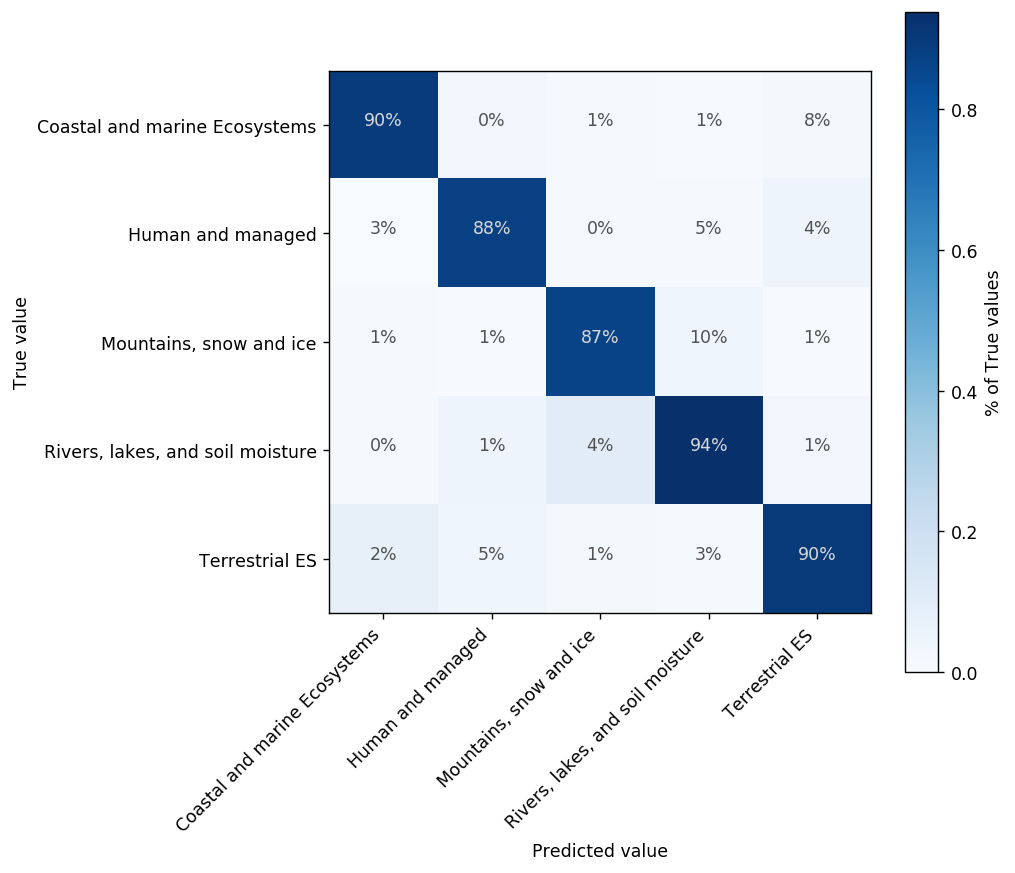

In [14]:
classes = broad_cats
print(classes)
cols = [f"{c} - k_prediction_binary" for c in classes]

y = np.matrix(df[broad_cats])

y_pred = np.array(list(df.loc[list(rel_index),cols].values))
   
y_true = y[rel_index]

confusion_matrix = np.zeros(shape=(len(classes),len(classes)),dtype=int).T

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n

confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=0,keepdims=True)

fig, ax = plt.subplots(dpi=125, figsize=(7,7))

mat = ax.imshow(confusion_matrix, cmap="Blues")
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > 0.5:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(j,k, f"{confusion_matrix[j,k]:.0%}",ha="center",color=color)
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_ylabel("True value")
ax.set_xlabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)
cbar.set_label("% of True values")

plt.savefig('../plots/prediction_models/broad_category_confusion_recall.pdf', bbox_inches="tight")

## Subcategories

In [15]:
catids = [710,320,321,323,322,324]
cats = [Category.objects.get(pk=cid) for cid in catids]
all_classes = []
i = 0
broad_cats = []
for c in cats:
    bc = {"start":i,"name": c.name}
    for ec in c.equivalents.filter(level=4).exclude(name__icontains="<hidden>").order_by('name','level'):
        ecname = f"{ec.level} - {ec.name}"
        if ecname in df.columns and df[ecname].sum()>=5:
            all_classes.append(ecname)
            i+=1
    bc["end"] = i
    bc["size"] = i-bc["start"]
    broad_cats.append(bc)
            
print(len(all_classes))
broad_cats

46


[{'end': 9, 'name': 'Physical systems', 'size': 9, 'start': 0},
 {'end': 13, 'name': 'Mountains, snow and ice', 'size': 4, 'start': 9},
 {'end': 20,
  'name': 'Rivers, lakes, and soil moisture',
  'size': 7,
  'start': 13},
 {'end': 27, 'name': 'Coastal and marine Ecosystems', 'size': 7, 'start': 20},
 {'end': 36, 'name': 'Terrestrial ES', 'size': 9, 'start': 27},
 {'end': 46, 'name': 'Human and managed', 'size': 10, 'start': 36}]

In [16]:
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier


new_rel_index = physical_index.intersection(rel_index)


import scoping.utils.learning_utils as lu

from importlib import reload  
reload(scoping.utils.learning_utils)
y = np.matrix(df[all_classes])
print(y.shape)

multimodels = [
    {
       'title': 'One vs rest SVC balanced rbf', 
       'model': OneVsRestClassifier(SVC(kernel='rbf', probability=True, class_weight="balanced"))
    },   
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },  
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_all_classes, metrics, df = lu.cross_validate_models(X, y, multimodels, new_rel_index, n_splits=5, classes=all_classes, df = df)


(2312, 46)
1


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

2


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no 

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 0 is present in all training examples.
  str(classes[c]))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no 

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


3


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

4


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

5


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1465: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)
/home/galm/software/django

/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


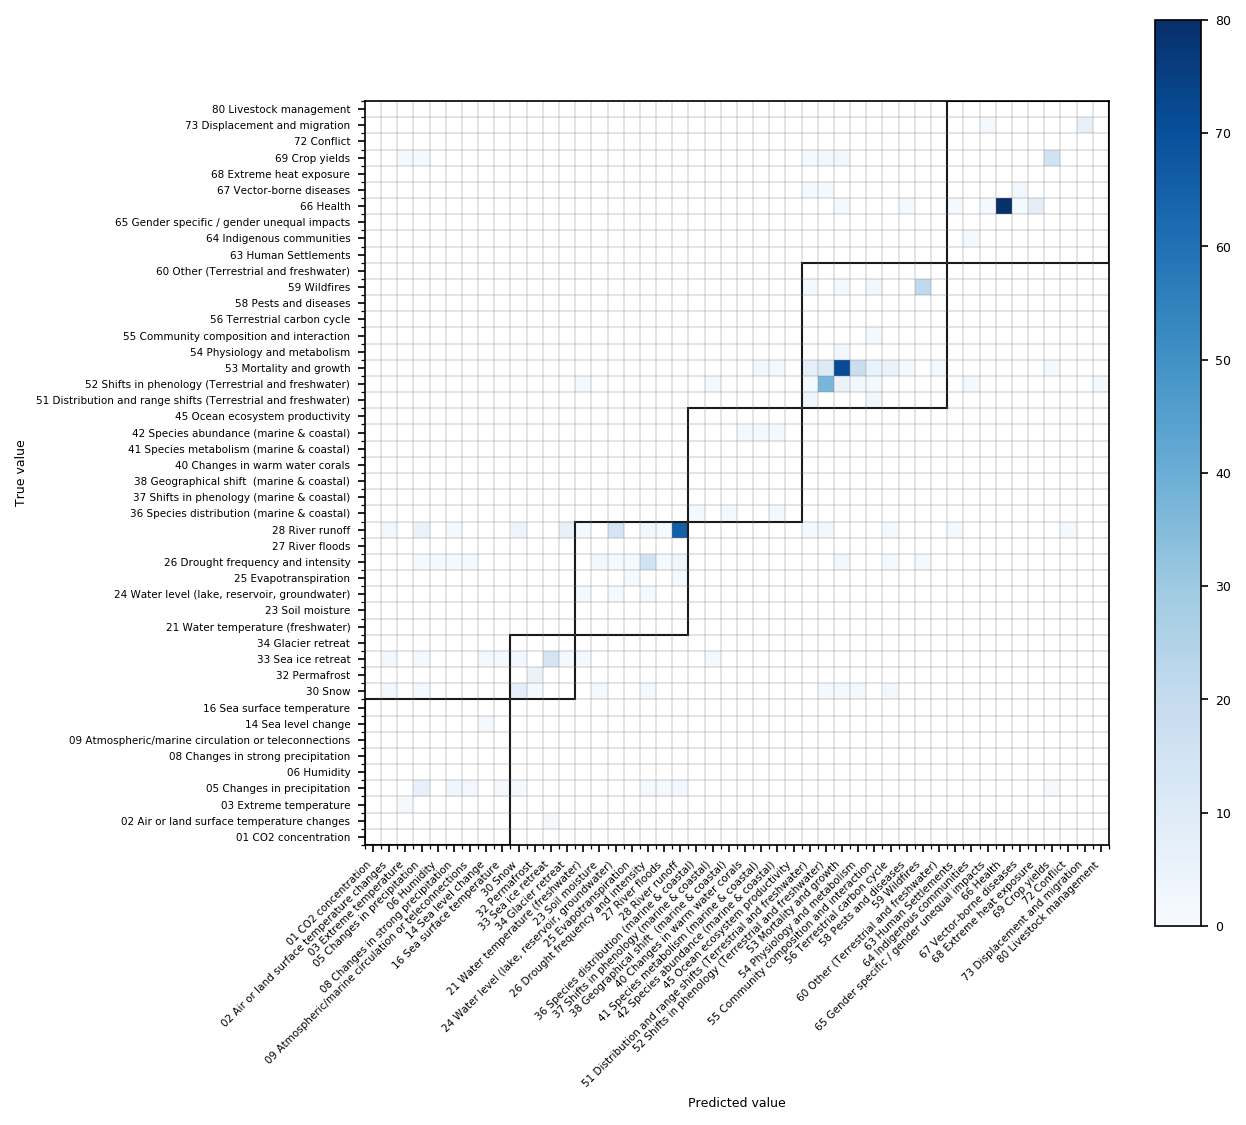

In [17]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(8,8),dpi=150)

cols = [f"{c} - k_prediction_binary" for c in all_classes]
y_pred = np.array(list(df.loc[list(physical_index),cols].values))
   
y_true = y[physical_index]

confusion_matrix = np.zeros(shape=(len(cols),len(cols)),dtype=float).T

for j, c in enumerate(all_classes):
    for k, c in enumerate(all_classes):
        n = 0
        for i in range(len(physical_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n


def plot_confusion_matrix(cm, norm=None, broad_cats = [], ls=False):
    cm = np.copy(cm)
    if norm is not None:
        cm = cm/cm.sum(axis=norm,keepdims=True)
    cm[cm == 0] = np.nan

    mat = ax.imshow(cm, cmap="Blues",vmin=0,origin="lower")
    ax.set_xticks(np.arange(-.5, cm.shape[0], 1), minor=True);
    ax.set_yticks(np.arange(-.5, cm.shape[0], 1), minor=True);

    ax.grid(which="minor",color='grey', linestyle='-', linewidth=0.2)

    if ls:
        for j, c in enumerate(all_classes):
            for k, c in enumerate(all_classes):
                n  = cm[j,k]
                if n > 0.5:
                    color="#d9d9d9"
                else:
                    color="#525252"
                ax.text(j,k, f"{cm[j,k]:.0%}",ha="center",color=color)

    ax.set_xticks(list(range(len(all_classes))))
    ax.set_xticklabels([x.replace("4 - ","") for x in all_classes],rotation=45,ha="right",fontsize=5)

    ax.set_yticks(list(range(len(all_classes))))
    ax.set_yticklabels([x.replace("4 - ","") for x in all_classes],ha="right",fontsize=5)
    ax.set_ylabel("True value", fontsize=6)
    ax.set_xlabel("Predicted value", fontsize=6)


    cbar = fig.colorbar(mat, ax=ax)
    cbar.ax.tick_params(labelsize=6)
    
    if norm ==1:
        cbar.set_label("% of True values")
    
    for bc in broad_cats:
        rect = patches.Rectangle((bc['start']-0.5,bc['start']-0.5),bc['size'],bc['size'],fill=False)
        ax.add_patch(rect)
    
plot_confusion_matrix(confusion_matrix,broad_cats=broad_cats)

plt.savefig(f'../plots/prediction_models/confusion_all_classes.pdf',bbox_inches="tight")


/home/galm/software/django/tmv/venv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


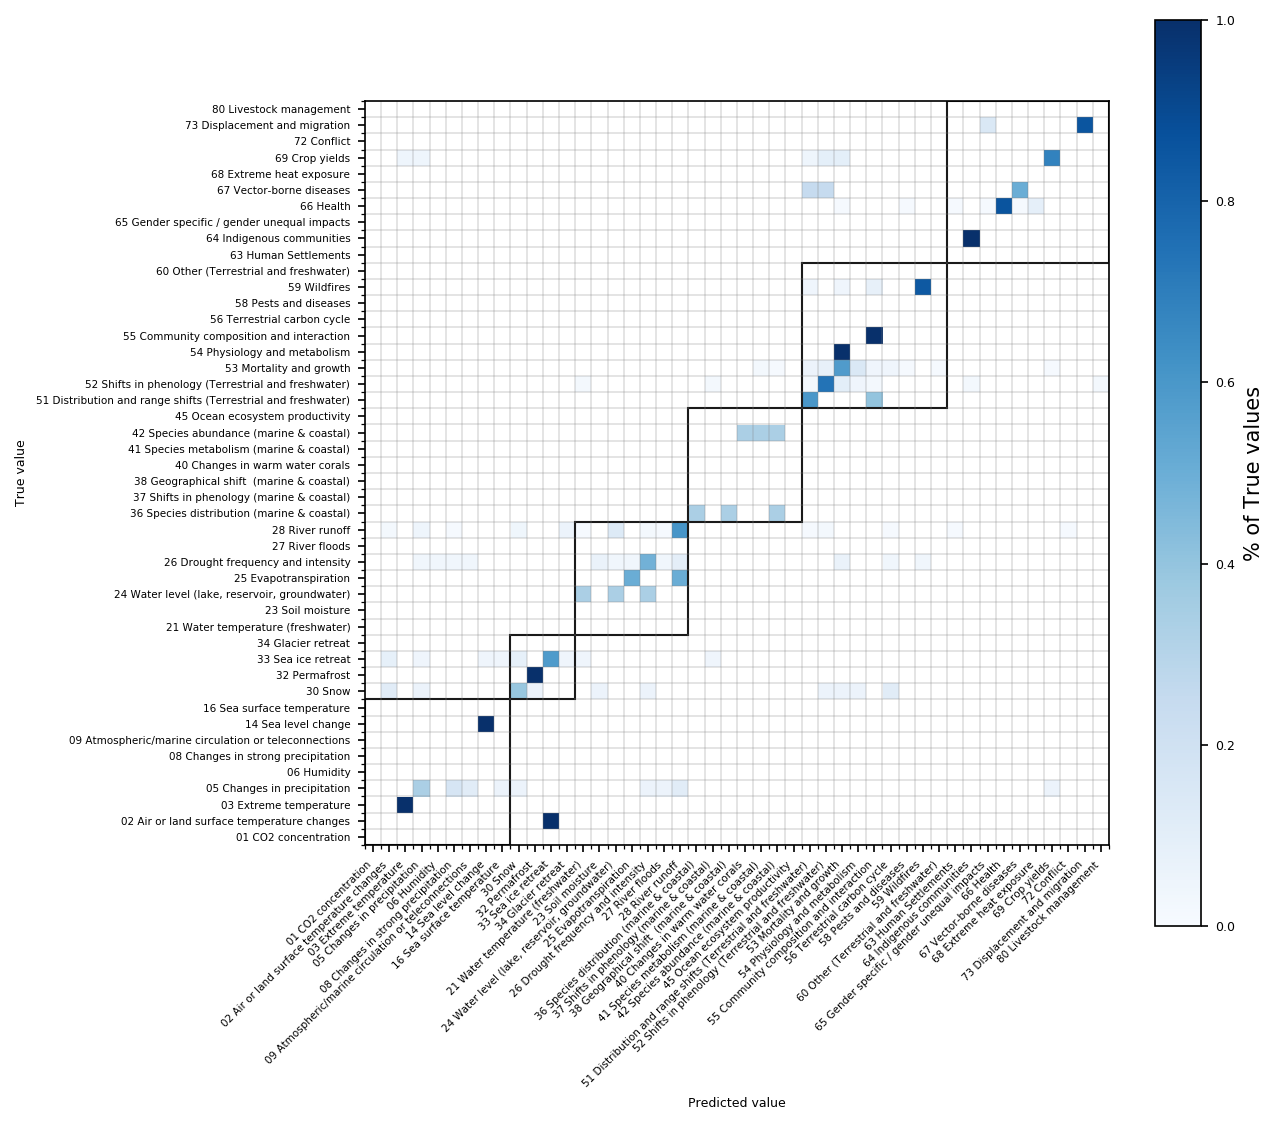

In [18]:
fig, ax = plt.subplots(figsize=(8,8),dpi=150)
plot_confusion_matrix(confusion_matrix,norm=1,broad_cats=broad_cats)
plt.savefig(f'../plots/prediction_models/confusion_all_classes_recall.pdf',bbox_inches="tight")

## Attribution prediction

In [19]:
df['2 - Trend or climate change attribution'] = 0
df.loc[
    (df['2 - 2.2 Trend attribution']==1) | (df['2 - 2.1. Climate change attribution']==1),
    '2 - Trend or climate change attribution'
] = 1

attribution_classes =  [
 '2 - Trend or climate change attribution',
 '2 - 2.4. Sensitivity',
 '2 - 2.5. Detection of a regional climate trend (no attribution)'
]

y = np.matrix(df[attribution_classes])


new_rel_index = physical_index.intersection(rel_index)
print(new_rel_index)
print(y.shape)

multimodels = [
    {
        'title': 'One vs rest SVC balanced', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },    
]


attribution_models, attribution_metrics, df = lu.cross_validate_models(X, y, multimodels, new_rel_index, n_splits=6, classes=attribution_classes, df =df)


Int64Index([   0,    3,    4,    5,    8,   10,   12,   18,   22,   23,
            ...
            2286, 2293, 2294, 2302, 2303, 2304, 2306, 2307, 2308, 2310],
           dtype='int64', length=868)
(2312, 3)
1
2
3
4
5
6


e
p
2 - Trend or climate change attribution
r
2 - Trend or climate change attribution
p
2 - 2.4. Sensitivity
r
2 - 2.4. Sensitivity
p
2 - 2.5. Detection of a regional climate trend (no attribution)
r
2 - 2.5. Detection of a regional climate trend (no attribution)


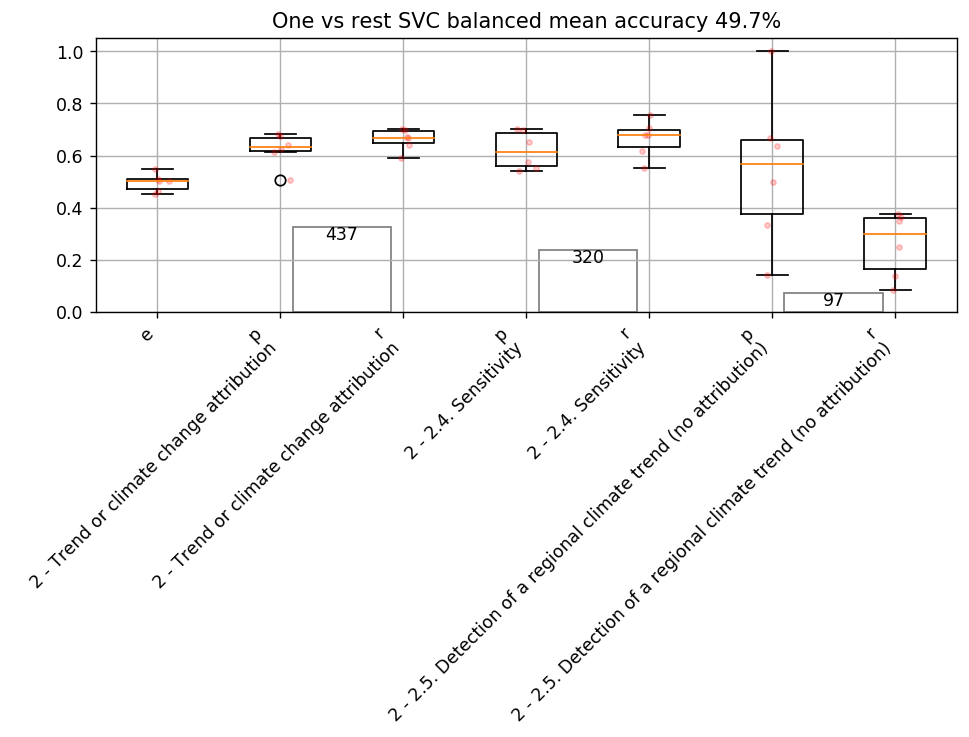

In [20]:
fig, axs = plt.subplots(1, 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(attribution_models, attribution_metrics, fig, axs)
ax = axs[0]
for i,m in enumerate(attribution_metrics):
    print(m)
    if len(m)>2:
        v,c = m.split('\n')
        s = df[c].sum()/len(rel_index)
        if v=="p":
            ax.text(i+1.5,s-0.03,int(df[c].sum()),ha="center",va="center")
            ax.bar(i+1.5,s,color="none",edgecolor="grey")
        
ax.set_xticklabels([x for x in attribution_metrics], rotation=45, ha="right")
plt.show()

['2 - Trend or climate change attribution', '2 - 2.4. Sensitivity', '2 - 2.5. Detection of a regional climate trend (no attribution)']


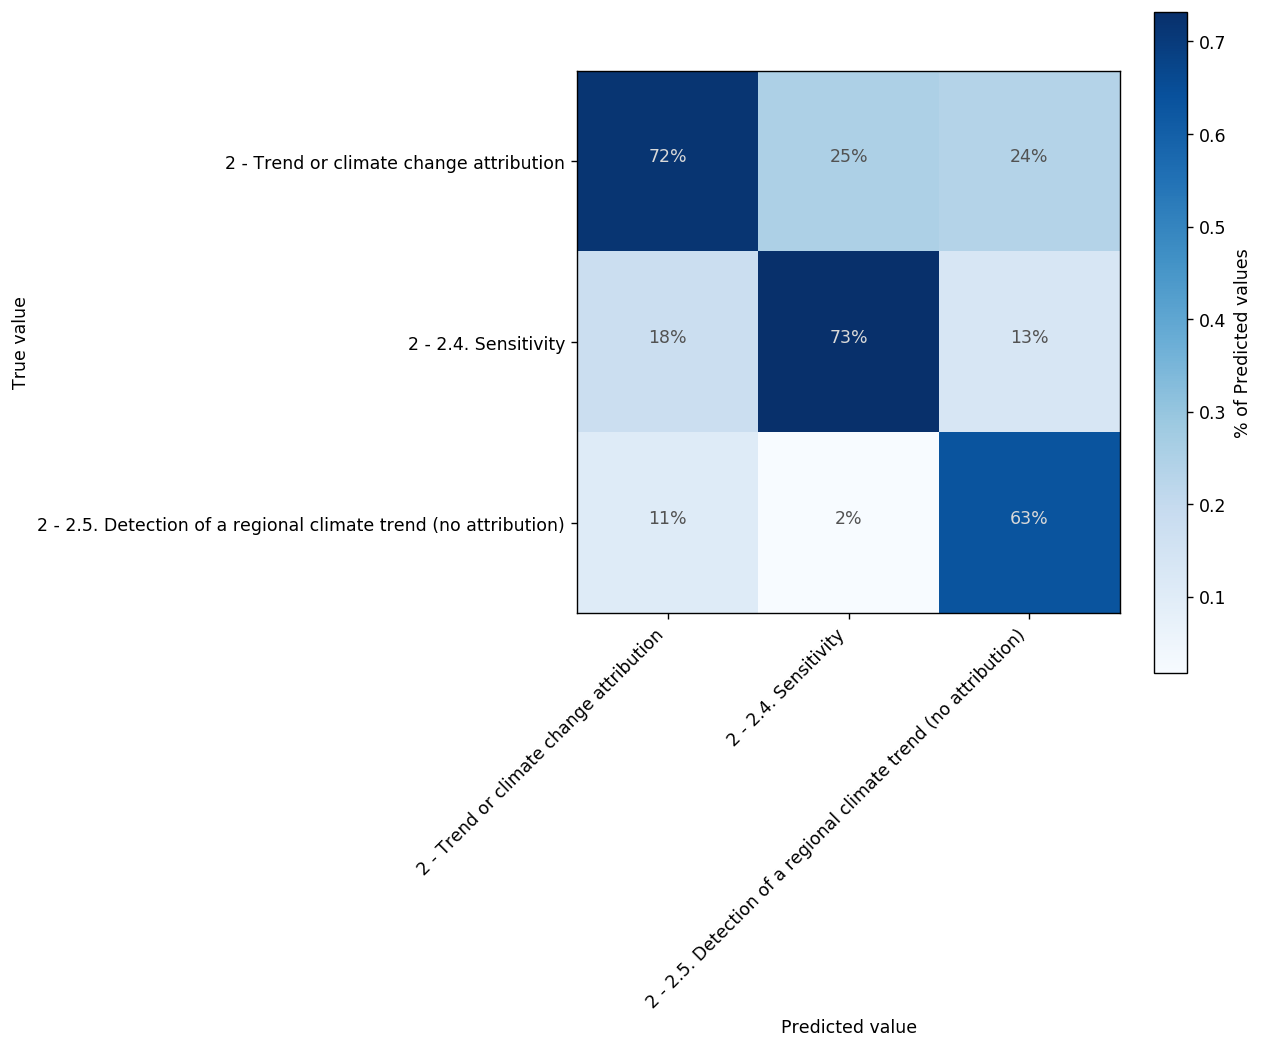

In [21]:
classes = attribution_classes
print(classes)
cols = [f"{c} - k_prediction_binary" for c in classes]

y = np.matrix(df[attribution_classes])

y_pred = np.array(list(df.loc[list(rel_index),cols].values))
   
y_true = y[rel_index]

confusion_matrix = np.zeros(shape=(len(classes),len(classes)),dtype=int)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
#confusion_matrix = confusion_matrix.T

confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1,keepdims=True)

confusion_matrix = confusion_matrix.T

fig, ax = plt.subplots(dpi=125, figsize=(7,7))

mat = ax.imshow(confusion_matrix, cmap="Blues")
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[k,j]
        if n > 0.5:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(j,k, f"{confusion_matrix[k,j]:.0%}",ha="center",color=color)
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_ylabel("True value")
ax.set_xlabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)
cbar.set_label("% of Predicted values")

plt.savefig('../plots/prediction_models/attribution_category_confusion_precision.pdf', bbox_inches="tight")

In [22]:
confusion_matrix

array([[0.71727749, 0.25      , 0.23684211],
       [0.17539267, 0.73188406, 0.13157895],
       [0.10732984, 0.01811594, 0.63157895]])

In [23]:
## New summary cats
df['6 - Precipitation'] = 0
df.loc[(df['6 - 05 Changes in precipitation']==1) | (df['6 - 08 Changes in strong precipitation']==1),"6 - Precipitation"] = 1

df['Human drivers'] = 0
df.loc[
    (df['6 - 76 Human water use']==1) |
    (df['6 - 77 Land use change']==1),
    '6 - Human drivers' 
] = 1
 
df.loc[
    (df['6 - 03 Extreme temperature']==1) & 
    (df['6 - 16 Sea surface temperature']==0) & 
    (df['6 - 21 Water temperature (freshwater)']==0),
    '6 - 02 Air or land surface temperature changes'
] = 1

df['6 - Temperature'] = 0
df.loc[
    (df['6 - 03 Extreme temperature']==1) | 
    (df['6 - 16 Sea surface temperature']==1) | 
    (df['6 - 02 Air or land surface temperature changes']==1) |
    (df['6 - 21 Water temperature (freshwater)']==1),
    '6 - Temperature'
] = 1

df['6 - Water availability'] = 0
df.loc[
    (df['6 - 26 Drought frequency and intensity']==1) |
    (df['6 - 07 Aridity/dryness']==1) |
    (df['6 - 28 River runoff']==1),
    '6 - Water availability'
] = 1

df['6 - Other'] = 0
df.loc[
    (df['6 - Temperature']==0) & 
    (df['6 - Precipitation']==0),
    '6 - Other'
] = 1

new_rel_index = physical_index.intersection(rel_index)

driver_selection = [
    #'6 - 01 CO2 concentration',
    '6 - Temperature',
    '6 - Precipitation',#'6 - 16 Sea surface temperature',
    '6 - Other'
    #'6 - 09 Atmospheric/marine circulation or teleconnections',
    #'6 - 10 Wind speed','6 - 11 Storms','6 - 14 Sea level change',#'6 - 26 Drought frequency and intensity',
    #'6 - 04 Radiation',
    #'6 - 33 Sea ice retreat',
    #'6 - No drivers', '6 - 30 Snow', '6 - Human drivers', 
    #'6 - 12 Seasonality',
    #'6 - Water availability',
]

In [24]:
classes = driver_selection

from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

import scoping.utils.learning_utils as lu

from importlib import reload  
#reload(scoping.utils.learning_utils)
y = np.matrix(df[classes])
print(y.shape)

multimodels = [
#     {
#        'title': 'One vs rest SVC balanced rbf', 
#        'model': OneVsRestClassifier(SVC(kernel='rbf', class_weight="balanced", probability=True))
#     },
    {
        'title': 'One vs rest SVC balanced lin', 
        'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True))
    },
#     {
#         'title': 'One vs rest SVC balanced lin c10', 
#         'model': OneVsRestClassifier(SVC(kernel='linear', class_weight="balanced", probability=True, C=10))
#     },
    #{
    #    'title': 'Random forest', 
    #    'model': OneVsRestClassifier(RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0, class_weight="balanced"))
    #},
    
    
]

#multimodels_ar5, metrics = lu.cross_validate_models(X, y, multimodels, seen_index, classes=classes)
multimodels_drivers_few, metrics, df = lu.cross_validate_models(X, y, multimodels, new_rel_index, n_splits=6, classes=classes, df = df)

(2312, 3)
1
2
3
4
5
6


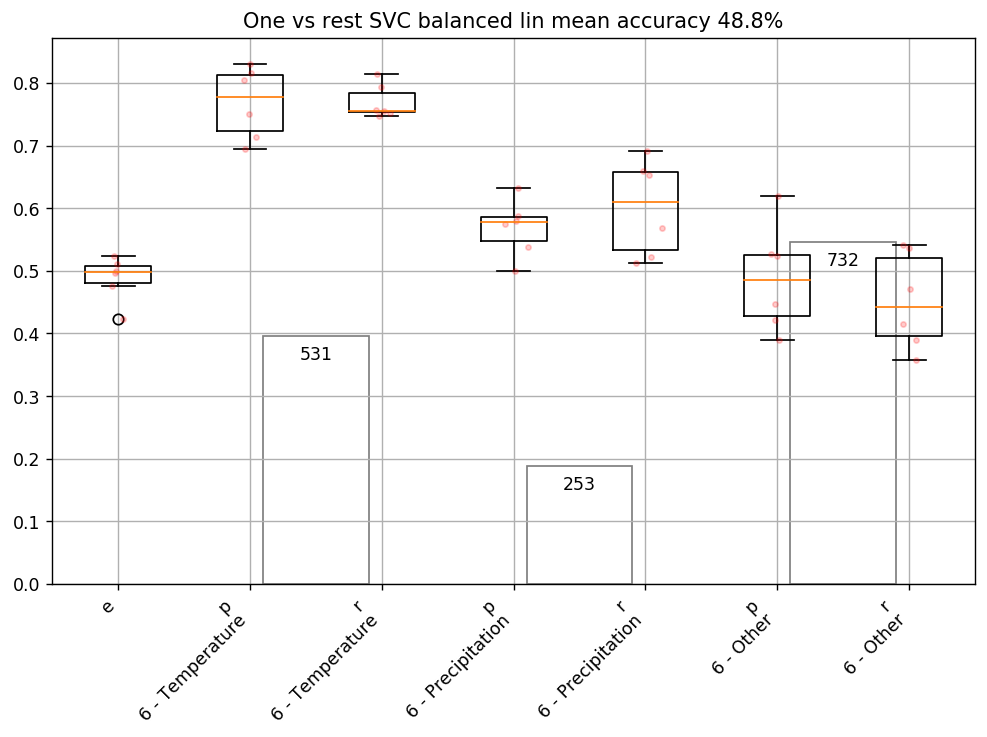

In [25]:
fig, axs = plt.subplots(len(multimodels_drivers_few), 1,dpi=125,figsize=(8,6),sharey=False,sharex=True)   
if str(type(axs))=="<class 'matplotlib.axes._subplots.AxesSubplot'>":
    axs = [axs]
lu.plot_model_output(multimodels_drivers_few, metrics, fig, axs)
for ax in axs:#ax = axs[0]
    for i,m in enumerate(metrics):
        if len(m)>2:
            v,c = m.split('\n')
            s = df.loc[rel_index,c].sum()/len(rel_index)
            if v=="p":
                ax.text(i+1.5,s-0.03,int(df.loc[rel_index,c].sum()),ha="center",va="center")
                ax.bar(i+1.5,s,color="none",edgecolor="grey")

    ax.set_xticklabels([x.replace('12 - ','') for x in metrics], rotation=45, ha="right")
plt.show()

['6 - Temperature', '6 - Precipitation', '6 - Other']


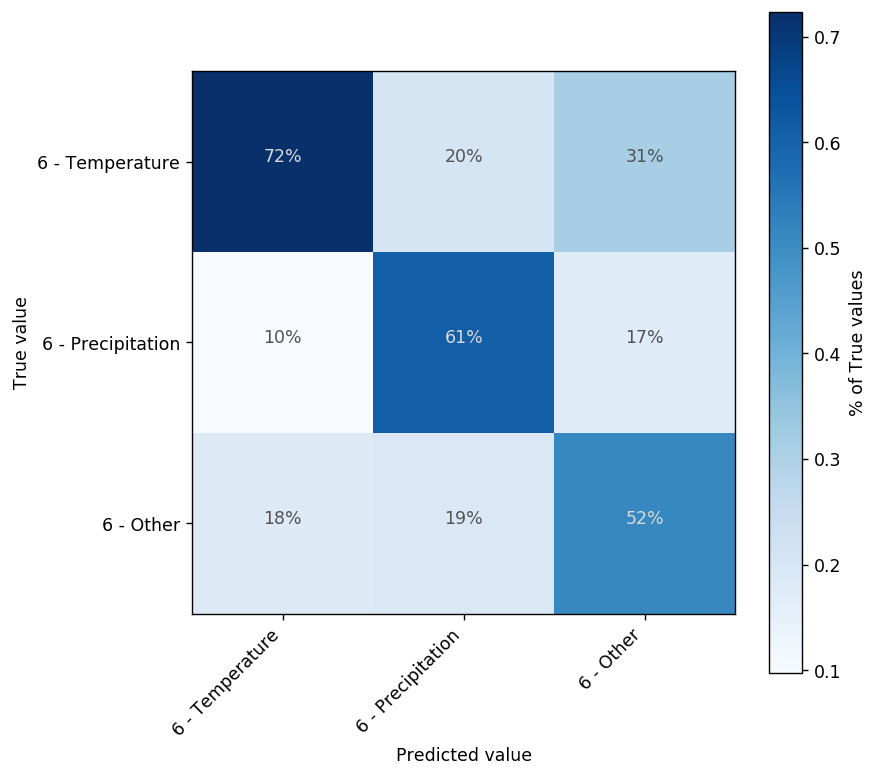

In [26]:
classes = driver_selection
print(classes)
cols = [f"{c} - k_prediction_binary" for c in classes]

y = np.matrix(df[driver_selection])

y_pred = np.array(list(df.loc[list(rel_index),cols].values))
   
y_true = y[rel_index]

confusion_matrix = np.zeros(shape=(len(classes),len(classes)),dtype=int)

for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n = 0
        for i in range(len(rel_index)):
            if j==k:
                if y_pred[i,j]+y_true[i,k]==2:
                    n+=1
            else:
                if y_pred[i,j]+y_true[i,k]==2 and y_pred[i,k]+y_true[i,k]!=2:
                    n+=1
        confusion_matrix[j,k]=n
        
#confusion_matrix = confusion_matrix.T

confusion_matrix = confusion_matrix/confusion_matrix.sum(axis=1,keepdims=True)

confusion_matrix = confusion_matrix.T

fig, ax = plt.subplots(dpi=125, figsize=(7,7))

mat = ax.imshow(confusion_matrix, cmap="Blues")
for j, c in enumerate(classes):
    for k, c in enumerate(classes):
        n  = confusion_matrix[j,k]
        if n > 0.5:
            color="#d9d9d9"
        else:
            color="#525252"
        ax.text(j,k, f"{confusion_matrix[k,j]:.0%}",ha="center",color=color)
        
ax.set_xticks(list(range(len(classes))))
ax.set_xticklabels([x.replace("12 - ","") for x in classes],rotation=45,ha="right")

ax.set_yticks(list(range(len(classes))))
ax.set_yticklabels([x.replace("12 - ","") for x in classes],ha="right")
ax.set_ylabel("True value")
ax.set_xlabel("Predicted value")


cbar = fig.colorbar(mat, ax=ax)
cbar.set_label("% of True values")

plt.savefig('../plots/prediction_models/driver_category_confusion_recall.pdf', bbox_inches="tight")